# Tutorial

## Installation and Interface

Installation is described in the README of the base directory of FEASST.
Or visit the website at https://pages.nist.gov/feasst

### Python or C++?

Although this tutorial will focus upon the python interface, FEASST may also be utilized as a C++ library.
For a C++ example, see the file `tutorial/tutorial.cpp` which is virtually identical to the Python tutorial.
Thus Python tutorials are sufficient for learning the C++ library.
While the majority of FEASST users prefer the Python interface, FEASST is written almost entirely in C++ for speed.
Thus, both interfaces will be supported in the long term.

Some HPC clusters may not have the required Python libraries.
If that is the case, do not hesitate to give the C++ interface a try, even if you have never written C++ before.
For example, the only minor differences between `tutorial/tutorial.cpp` and `tutorial/tutorial.py` are the argument parsing syntax, semi-colons at the end of every line, and compiling any binary with `int main()`.

## Canonical ensemble Lennard-Jones Monte Carlo

The following simulation based on `tutorial/tutorial.py` demonstrates the basics of FEASST.

To begin, FEASST is imported, and it is recommended to log the exact version used for the simulation.

In [1]:
import feasst
print("version:", feasst.version())

version: v0.7.0-90-g6cb364c4ae hwh/branch


Then a [MonteCarlo](../plugin/monte_carlo/README.rst) object is created and the random number generator is initialized using the C++ implementation of the Mersenne Twister seeded by the time and date.

In [2]:
monte_carlo = feasst.MonteCarlo()
monte_carlo.set(feasst.MakeRandomMT19937(feasst.args({"seed" : "time"})))

Care must be taken not to run two identical simulations at the same second on an HPC node using the time and date, or they will have the same seed and may be equivalent. Instead, consider using a thread safe random number generator to seed the simulations.

FEASST standard output and error goes to the Jupyter notebook terminal.
Thus, you should see output like "# Info 0 [plugin/math/src/random.cpp:30] time(seed): 1572362164" but with a different seed. This seed is provided in case you wanted to reproduce your simulation exactly, which we will do now.
Note that your simulation may still be different than presented here, possibly because of different compiler implementations.

In [3]:
monte_carlo.set(feasst.MakeRandomMT19937(feasst.args({"seed" : "1572362164"})))

The second step is to add a [Configuration](../plugin/configuration/README.rst).
In this example, a simple cubic periodic box of length 8 is defined with a single type of particle as described in `forcefield/data.lj`.
See [Forcefield](../forcefield/README.rst) for more information about the format of the data file, which is a LAMMPS-inspired file with some major differences.

In [4]:
monte_carlo.add(feasst.Configuration(feasst.MakeDomain(feasst.args({"cubic_box_length": "8"})),
     feasst.args({"particle_type": feasst.install_dir() + "/forcefield/data.lj"})))

FEASST arguments are input as a dictionary of strings with limited type checking.
Thus, care must be taken to input strings which follow the documentation.

<!--- HWH add exercise: If there is a typo in the arguments, this may result in a FEASST      exception which will print to the terminal and crash the notebook kernel.
You can test this now by changing the `cubic_box_length` argument to an incorrect argument such as `cubic_box_length1`, you should seen an error like the following:

> terminate called after throwing an instance of 'feasst::CustomException'
>   what():  Throw on proc 0 : # Assertion `find_in_list(pair.first, used_keys_)` failed0 plugin/utils/src/arguments.cpp:66: Key arg(cubic_box_length1) ) is not recognized. Check for any typos in your provided keyword arguments and check documentation. All keywords provided in args must be used, otherwise, a simple typo in keyword arguments would go unnoticed. If you are a developer, check that you have processed all possible keywords in the appropriate constructor.
--->

Next, initializing the [Potential](../plugin/system/doc/Potential.rst) proceeds as follows:

In [5]:
monte_carlo.add(feasst.MakePotential(feasst.MakeLennardJones()))
monte_carlo.add(feasst.MakePotential(feasst.MakeLongRangeCorrections()))

In this example, we introduce both the pair-wise [Lennard-Jones (LJ) model](../plugin/system/doc/LennardJones.rst), and also [long-range corrections](../plugin/system/doc/LongRangeCorrections.rst), which approximately account for the cut off of the LJ potential by assuming a pair-wise radial distance distribution function of unity.
A FEASST convention is to use a helper function which appends the word `Make` onto the class name when creating pointers to FEASST derived class objects.
This serves two purposes involving C++11 smart pointers and brace enclosed initializer lists.

Initialize [ThermoParams](../plugin/system/doc/ThermoParams.rst), such as temperature, and the acceptance [Criteria](../plugin/monte_carlo/doc/Criteria.rst).

In [6]:
monte_carlo.set(feasst.MakeThermoParams(feasst.args({"beta": "1.5"})))
monte_carlo.set(feasst.MakeMetropolis())

A [TrialTranslate](../plugin/monte_carlo/doc/trials.rst) is then introduced which attempts to translate a random particle by a random distance which is bound in each dimension by a `tunable_param`.
This parameter may be adjusted to obtain a desired acceptance ratio, `tunable_target_acceptance`, with the help of [Tuner](../plugin/steppers/doc/Tuner.rst).


In [7]:
monte_carlo.add(feasst.MakeTrialTranslate(feasst.args(
    {"tunable_param": "2.", "tunable_target_acceptance": "0.2"})))
steps_per = int(1e3)
monte_carlo.add(feasst.MakeTuner(feasst.args({"steps_per" : str(steps_per)})))

With the help of [TrialTranslate](../plugin/monte_carlo/doc/trials.rst), we can now initialize the number of particles.

In [8]:
feasst.SeekNumParticles(50)\
    .with_thermo_params(feasst.args({"beta": "0.1", "chemical_potential": "10"}))\
    .with_metropolis()\
    .with_trial_add().run(monte_carlo)

A grand canonical simulation is performed here by utilizing a temporary [TrialAdd](../plugin/monte_carlo/doc/trials.rst), which is why chemical potential was input to [Criteria](../plugin/monte_carlo/doc/Criteria.rst).

Additional [Analyze](../plugin/monte_carlo/doc/Analyze.rst) or [Modify](../plugin/monte_carlo/doc/Modify.rst) may be added at any time to perform some task contingent upon the number of attempted trials.

In [9]:
monte_carlo.add(feasst.MakeLog(feasst.args({"steps_per" : str(steps_per),
                                            "file_name" : "log.txt",
                                            "clear_file" : "true"})))
monte_carlo.add(feasst.MakeMovie(feasst.args(
    {"steps_per" : str(steps_per), "file_name" : "movie.xyz"})))
monte_carlo.add(feasst.MakeCheckEnergy(feasst.args(
    {"steps_per" : str(steps_per), "tolerance" : "1e-8"})))

In this example, [Log](../plugin/steppers/doc/Log.rst) outputs the current status of the trials, [Movie](../plugin/steppers/doc/Movie.rst) outputs the configuration, and [CheckEnergy](../plugin/steppers/doc/CheckEnergy.rst) asserts that the optimized energy calculations match the unoptimized ones.

The simulation is finally run for a number of trial attempts.

In [10]:
%%time
monte_carlo.attempt(int(1e5))

CPU times: user 797 ms, sys: 3.79 ms, total: 801 ms
Wall time: 798 ms


Now we can analyze the simulation by, for example, plotting the instantaneous energy as a function of the number of attempts.

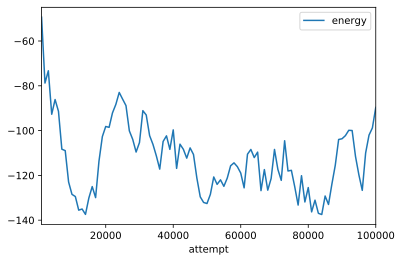

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
pd.read_csv("log.txt").plot('attempt', 'energy')

You should also find the `movie.xyz` trajectory file with an automatically-generated `movie.xyz.vmd` file for use with VMD (e.g., `vmd -e movie.xyz.vmd`).

Did this tutorial work as expected? Did you find any inconsistencies or have any comments? Please [contact](../CONTACT.rst) us. Any feedback is appreciated!

## Additional tutorials

After completing this basic tutorial, check out the tutorials specific to each [Plugin](../plugin/README.rst).
For example, see the tutorials of the [System](../plugin/system/README.rst), [MonteCarlo](../plugin/monte_carlo/README.rst) and [flat histogram](../plugin/flat_histogram/README.rst) plugins.